# Bond Maturity Strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# define some functions for calculations and metrics

def bond_price(par, T, ytm, coup, freq=1.):
    
    # function to compute the price of a bond

    # par : par value of bond

    # T   : time to maturity in year

    # ytm : yield to maturity 

    # coup: coupon amount

    # freq: frequency of coupon payout 
    
    freq = float(freq)
    periods = T*freq
    coupon = coup/100.*par/freq
    dt = [(i+1)/freq for i in range(int(periods))]
    price = sum([coupon/(1+ytm/freq)**(freq*t) for t in dt]) + par/(1+ytm/freq)**(freq*T)
    return price

def z_score(x,W):
    
    # function to get the rolling z score of a dataframe
    
    # x   : dataframe or series
    
    # W   : window length
    
    return (x - x.rolling(W).mean()) / x.rolling(W).std()

def ann_ret(r):
    
    # function to compute the annualized rate of return

    # r   : the dataframe or series containing returns
    
    years = (r.index[-1]-r.index[0]).days/365
    return (np.prod(1+r)**(1/years)-1)*100

def ann_vol(r,N):
    
    # function to compute the annualized volatility

    # r   : the dataframe or series containing returns
    
    # N   : the number of trading days in a year
    
    return r.std() * np.sqrt(N) * 100

def sharpe(r,N):
    
    # function to compute the sharpe ratio ( return / volatlity )

    # r   : the dataframe or series containing returns
    
    # N   : the number of trading days in a year
    
    return np.sqrt(N) * r.mean() / r.std()

def beta(r,br):
    
    # function to compute beta of strategy to a benchmark

    # r   : the series containing strategy returns
    
    # br  : the series containing benchmark returns
    
    return r.cov(br) / br.var()

def avg_dur(mask,lt_dur,st_dur):
    
    # function to average duration of portfolio
    
    # mask   : series containing portfolio weight (1 long term bond, 0 short term bond)
    
    # lt_dur : long term bond duration
    
    # st_dur : short term bond duration
    
    return mask.mean() * lt_dur + (1-mask.mean()) * st_dur

# set start and end dates

start_date = '1985-01-01'
end_date   = '2018-12-31'

# compile a dataframe of bond rates
# data sourced from Federal Reserve Economic Data:
# https://fred.stlouisfed.org

rate_info = {
    '3mo'  : {'file' : 'DTB3',  'years' :  0.25},
    '2yr'  : {'file' : 'DGS2',  'years' :  2.00},
    '5yr'  : {'file' : 'DGS5',  'years' :  5.00},
    '7yr'  : {'file' : 'DGS7',  'years' :  7.00},
    '10yr' : {'file' : 'DGS10', 'years' : 10.00},
}

columns = ['3mo','2yr','5yr','7yr','10yr']
rate_df = pd.concat([pd.read_csv('Data/'+rate_info[s]['file']+'.csv',index_col=0,parse_dates=True
                      )[rate_info[s]['file']].rename(s) for s in columns],axis=1
                   ).replace('.','nan').astype(float).ffill()[start_date:end_date]

# check number of trading days in a year for bond market:
day_counts = rate_df.groupby(rate_df.index.year).count().mean(axis=1).value_counts()
day_counts

261.0    22
260.0     8
262.0     4
dtype: int64

# Examining Bond and Rate Data

We assume 261 trading days in a year based on the above results and build bond total return indicies

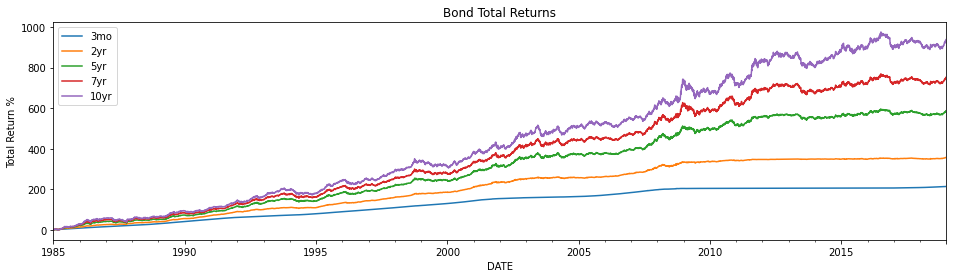

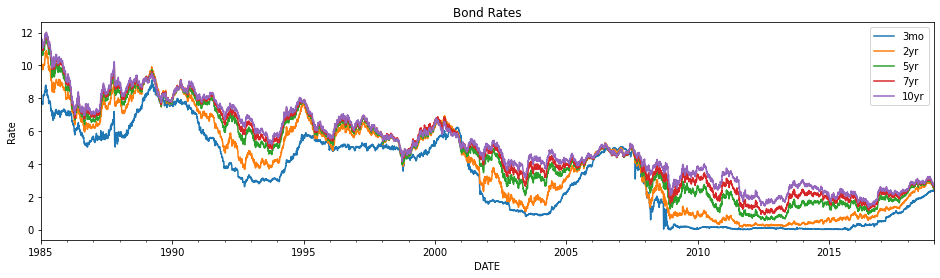

In [2]:
days_per_year = int(day_counts.index[0])
rate_T = pd.Series([rate_info[s]['years'] for s in columns],columns)
bond_df = pd.concat([bond_price(100,rate_T[s],rate_df[s]/100,rate_df[s].iloc[0]) for s in rate_df.columns],axis=1)
bond_tr_df = (1+bond_df.pct_change().fillna(0)+rate_df/(days_per_year*100)).cumprod()

(bond_tr_df*100-100).plot(figsize=(16,4),title='Bond Total Returns')
plt.ylabel('Total Return %')
plt.show()
plt.show()

rate_df.plot(figsize=(16,4),title='Bond Rates')
plt.ylabel('Rate')
plt.show()

# Try Strategy and Show Results

Here we experiement with a strategy that shortens the average maturity of a portfolio of bonds from 10 years to 2 years when the 10 year rate falls enough to produce a 1 year z-score of -2 and hold this position for one year. We compare it to a portfolio of 5 year government bonds which is fairly close to the maturity of the average US treasury bond:

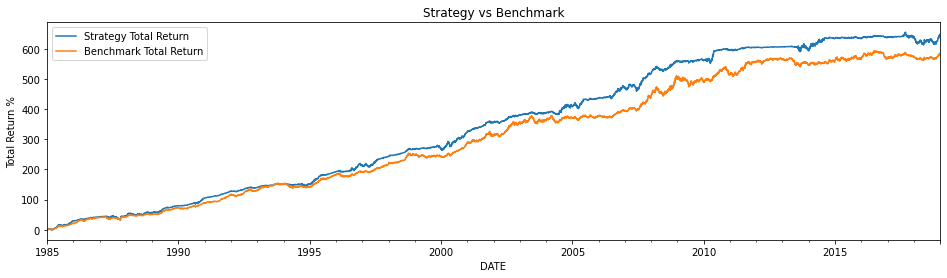

strategy_annualized_return         6.097
benchmark_annualized_return        5.826
strategy_annualized_volatility     3.689
benchmark_annualized_volatility    4.069
strategy_sharpe                    1.624
benchmark_sharpe                   1.414
strategy_beta                      0.685
strategy_average_duration          4.625
benchmark_average_duration         5.000
dtype: float64


In [3]:
def show_results(bond_tr_df,rate_info,days_per_year,years_to_hold=1,
               z_score_threshold=2,lt_dur='10yr',st_dur='2yr',b_dur='5yr'):
    
    # function to test a bond duration strategy
    
    # bond_tr_df       : dataframe containing the total returns various bond portfolios
    
    # rate_info        : a dictionary containing rate meta data
    
    # days_per_year    : number of trading days in a year for bonds
    
    # years_to_hold    : number of years to hold short term bond position 
    
    # z_score_threshold: required z-score to switch to short term portfolio
    
    # lt_dur           : long term bond maturity 
    
    # st_dur           : short term bond maturity 
    
    # b_dur            : benchmark maturity
    
    # create a vector mask that decides the holding of long or short term bonds 
    # and multiply by return vector
    
    mask = rate_df[lt_dur] + np.nan
    zs = z_score(rate_df[lt_dur],days_per_year)
    mask[ zs < -z_score_threshold] = 0
    mask = mask.ffill(limit=days_per_year * years_to_hold).fillna(1).shift()
    strat_r = mask * bond_tr_df.pct_change()[lt_dur] + (1-mask) * bond_tr_df.pct_change()[st_dur]
    benchmark_r = bond_tr_df.pct_change()[b_dur]
    
    # compute metrics for strategy and benchmark
    
    stats = pd.Series({
        'strategy_annualized_return'  : ann_ret(strat_r),
        'benchmark_annualized_return' : ann_ret(benchmark_r),
        'strategy_annualized_volatility'  : ann_vol(strat_r,days_per_year),
        'benchmark_annualized_volatility' : ann_vol(benchmark_r,days_per_year),
        'strategy_sharpe'  : sharpe(strat_r,days_per_year),
        'benchmark_sharpe' : sharpe(benchmark_r,days_per_year),
        'strategy_beta' : beta(strat_r, benchmark_r),
        'strategy_average_duration' : avg_dur(mask,rate_info[lt_dur]['years'],rate_info[st_dur]['years']),
        'benchmark_average_duration' : rate_info[b_dur]['years'],
    }).round(3)
    
    # plot results
    
    ((1+strat_r).cumprod()*100-100).plot(figsize=(16,4),label='Strategy Total Return',title='Strategy vs Benchmark')
    ((1+benchmark_r).cumprod()*100-100).plot(figsize=(16,4),label='Benchmark Total Return')
    plt.ylabel('Total Return %')
    plt.legend()
    plt.show()
    print( stats )
    
show_results(bond_tr_df,rate_info,days_per_year)

# Short Discussion of Results

Here we see that the strategy produces slightly higher returns than the bench mark with slightly lower volatlity leading to a higher sharpe ratio despite having a lower average duration over the studied period of time. When combined with other quantittive and qualitative pieces of information this strategy may be useful in deciding if some amount of shortening of lengthening of portfolio maturity makes sense.